<a href="https://colab.research.google.com/github/marioapn3/Fix-Sea-Animal-Dataset-Imbalanced/blob/main/Fix_Imbalanced_on_Dataset_Sea_Animal_%F0%9F%A6%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sea-animals-image-dataste:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2442436%2F5198507%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240823%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240823T090332Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D19defcde7f3ec8d8a60efa1c09c3659c32534653f7694559f026625eb53fe07d7da3646adf72b9a5012b8cc097c0f7c125768115822ac17c46392aee75158e2974d383a85dc32d07cc8cf8c846392b0d8e59756f503818a980a13cd5b05d384bf33c520e1c30a8e8097d3d06a16b90fd0915987292b1f5a1cf55879c4fa20e2db8ba609d69ffa4527e95f8e8fededd29f398471d38c93478e17cefdc58b63583ccdc9cf4f634b035b197c62eca26f248f78f4888dcd1fc6208077fed9e2c697c420c6e7e3de55cd5efb95d28eff64ffd262daf149a8996be78ee7497d622c3ee90564d4255091ff9a6ec06939ee88b38a5d02cd20ae9a61dd7cb2aef8a120a8b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# Importing necessary libraries
import os
import random
import shutil
import numpy as np
import pandas as pd

# For pretty table
from prettytable import PrettyTable

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

# For data generators and deep learning
import pathlib
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Dense, Flatten
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-08-23 08:29:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py'

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-08-23 08:29:06 (72.8 MB/s) - 'helper_functions.py' saved [10246/10246]



In [ ]:
def TotalImages(path):
    src = os.listdir(path)
    data = []

    for lb in src:
        x = os.path.join(path, lb)
        y = os.listdir(x)
        data.append([lb, len(y)])

    # Create the table using tabulate
    table = tabulate(data, headers=["Label", "Number of Images"], tablefmt="fancy_grid")

    # Print the table
    print(table)

In [ ]:
dataset_path = "/kaggle/input/sea-animals-image-dataste/"

labels = os.listdir(dataset_path)

# Create a new PrettyTable instance
table = PrettyTable()
table.add_column("Labels", labels)

# Set table alignment
table.align = "l"
print(table)


+-----------------+
| Labels          |
+-----------------+
| Penguin         |
| Clams           |
| Lobster         |
| Otter           |
| Eel             |
| Corals          |
| Puffers         |
| Squid           |
| Whale           |
| Sea Urchins     |
| Crabs           |
| Starfish        |
| Seal            |
| Octopus         |
| Shrimp          |
| Sharks          |
| Sea Rays        |
| Fish            |
| Seahorse        |
| Nudibranchs     |
| Dolphin         |
| Turtle_Tortoise |
| Jelly Fish      |
+-----------------+


In [ ]:
TotalImages(dataset_path)

╒═════════════════╤════════════════════╕
│ Label           │   Number of Images │
╞═════════════════╪════════════════════╡
│ Penguin         │                482 │
├─────────────────┼────────────────────┤
│ Clams           │                497 │
├─────────────────┼────────────────────┤
│ Lobster         │                499 │
├─────────────────┼────────────────────┤
│ Otter           │                500 │
├─────────────────┼────────────────────┤
│ Eel             │                497 │
├─────────────────┼────────────────────┤
│ Corals          │                500 │
├─────────────────┼────────────────────┤
│ Puffers         │                531 │
├─────────────────┼────────────────────┤
│ Squid           │                483 │
├─────────────────┼────────────────────┤
│ Whale           │                572 │
├─────────────────┼────────────────────┤
│ Sea Urchins     │                579 │
├─────────────────┼────────────────────┤
│ Crabs           │                499 │
├───────────────

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


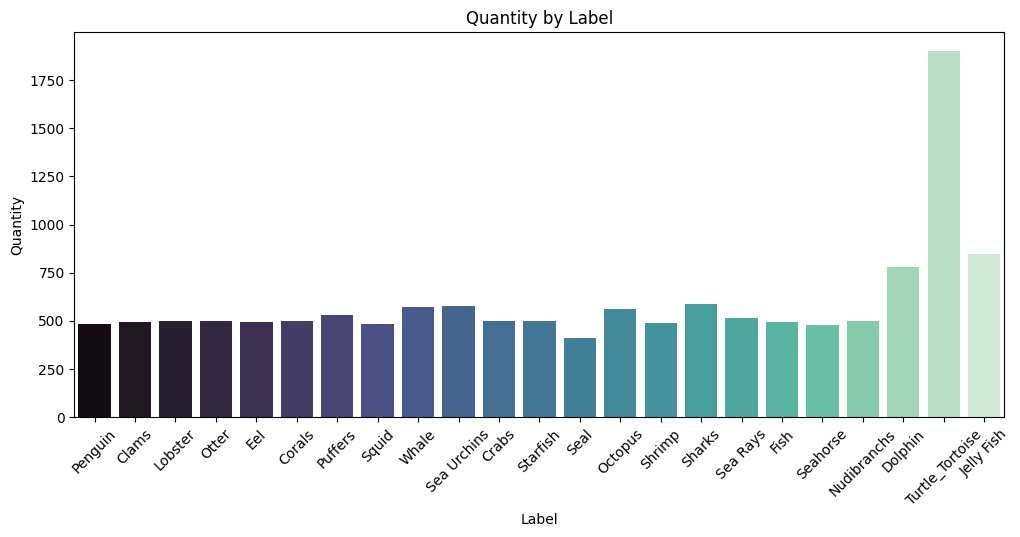

In [ ]:
src = os.listdir(dataset_path)
data = []

for lb in src:
    x = os.path.join(dataset_path, lb)
    y = os.listdir(x)
    data.append(len(y))

plt.figure(figsize=(12, 5))

sns.barplot(x=labels, y=data, palette= "mako")

# Set plot title and labels
plt.title("Quantity by Label")
plt.xlabel("Label")
plt.ylabel("Quantity")
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [ ]:
#remove existing directory if any
#uncomment the last line if required.


def remove_directory(directory_path):
    # Iterate over all files and directories within the directory
    for root, dirs, files in os.walk(directory_path, topdown=False):
        # Remove files
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)

        # Remove subdirectories
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            shutil.rmtree(dir_path)

    # Remove the main directory itself
    shutil.rmtree(directory_path)

# Specify the path to the directory you want to remove
output_path = "/kaggle/working/sea-animals-image-dataset/"

# Call the remove_directory function
remove_directory(output_path)



In [ ]:
import shutil
import os

# Definisikan path dataset dan output
dataset_path = "/kaggle/input/sea-animals-image-dataste/"
output_path = "/kaggle/working/sea-animals-image-dataset/"

# Buat direktori output_path jika belum ada
os.makedirs(output_path, exist_ok=True)

# Dapatkan semua nama folder di dalam dataset_path
folders = os.listdir(dataset_path)

# Pindahkan setiap folder dan isinya ke output_path
for folder in folders:
    src_folder = os.path.join(dataset_path, folder)
    dest_folder = os.path.join(output_path, folder)

    # Salin folder beserta isinya ke output_path
    shutil.copytree(src_folder, dest_folder)

print("Semua folder dan file berhasil dipindahkan ke:", output_path)


Semua folder dan file berhasil dipindahkan ke: /kaggle/working/sea-animals-image-dataset/


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
TARGET_SIZE = (224, 224)

datagen = ImageDataGenerator(
            width_shift_range=0.2,
            height_shift_range=0.2,
            brightness_range = (0.3, 0.9),
            zoom_range=0.2)


def Augmentation(path, capacity):
    # Ambil semua label (nama folder)
    labels = os.listdir(path)

    for label in labels:
        if label == 'Turtle_Tortoise':  # Lewati folder yang tidak ingin di-augment
            continue

        image_directory = os.path.join(path, label)
        dataset = []

        print(f"Processing {label} in {image_directory}")
        my_images = os.listdir(image_directory)
        for image_name in my_images:
            if image_name.split('.')[-1].lower() == 'jpg':
                image = load_img(os.path.join(image_directory, image_name), target_size=TARGET_SIZE)
                image = img_to_array(image)
                dataset.append(image)

        x = np.array(dataset)
        i = 0
        for batch in datagen.flow(x, batch_size=16,
                                  save_to_dir=image_directory,  # Simpan di direktori yang sama
                                  save_prefix='aug',
                                  save_format='jpg'):
            i += 1
            if i >= capacity:  # Berhenti ketika jumlah augmentasi mencapai kapasitas
                break


In [ ]:
output_path = "/kaggle/working/sea-animals-image-dataset"

Augmentation(output_path, 70)

Processing Jelly Fish in /kaggle/working/sea-animals-image-dataset/Jelly Fish
Processing Sea Urchins in /kaggle/working/sea-animals-image-dataset/Sea Urchins
Processing Eel in /kaggle/working/sea-animals-image-dataset/Eel
Processing Lobster in /kaggle/working/sea-animals-image-dataset/Lobster
Processing Penguin in /kaggle/working/sea-animals-image-dataset/Penguin
Processing Dolphin in /kaggle/working/sea-animals-image-dataset/Dolphin
Processing Corals in /kaggle/working/sea-animals-image-dataset/Corals
Processing Squid in /kaggle/working/sea-animals-image-dataset/Squid
Processing Sharks in /kaggle/working/sea-animals-image-dataset/Sharks
Processing Whale in /kaggle/working/sea-animals-image-dataset/Whale
Processing Sea Rays in /kaggle/working/sea-animals-image-dataset/Sea Rays
Processing Fish in /kaggle/working/sea-animals-image-dataset/Fish
Processing Octopus in /kaggle/working/sea-animals-image-dataset/Octopus
Processing Crabs in /kaggle/working/sea-animals-image-dataset/Crabs
Proces

In [ ]:
TotalImages(output_path)

╒═════════════════╤════════════════════╕
│ Label           │   Number of Images │
╞═════════════════╪════════════════════╡
│ Jelly Fish      │               1959 │
├─────────────────┼────────────────────┤
│ Sea Urchins     │               1685 │
├─────────────────┼────────────────────┤
│ Eel             │               1617 │
├─────────────────┼────────────────────┤
│ Lobster         │               1591 │
├─────────────────┼────────────────────┤
│ Penguin         │               1572 │
├─────────────────┼────────────────────┤
│ Dolphin         │               1892 │
├─────────────────┼────────────────────┤
│ Corals          │               1592 │
├─────────────────┼────────────────────┤
│ Turtle_Tortoise │               1903 │
├─────────────────┼────────────────────┤
│ Squid           │               1603 │
├─────────────────┼────────────────────┤
│ Sharks          │               1705 │
├─────────────────┼────────────────────┤
│ Whale           │               1685 │
├───────────────

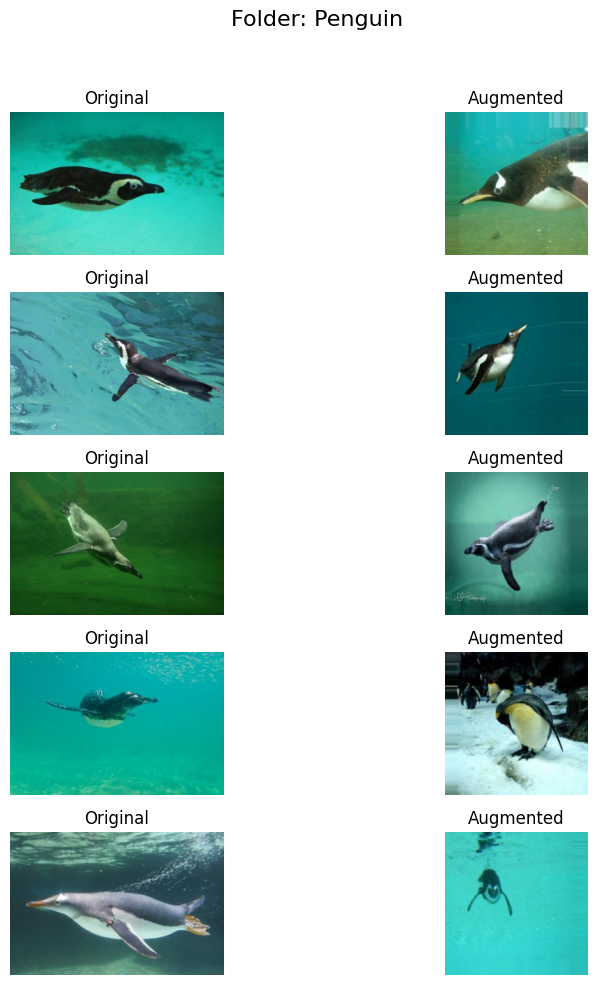

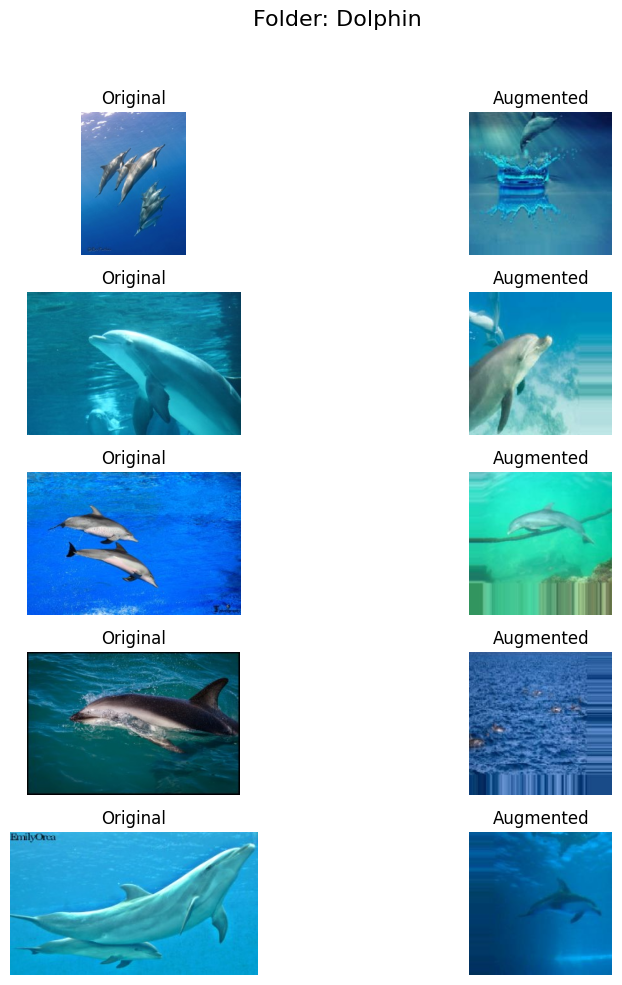

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def display_images(original_dir, augmented_dir, folder_names, num_images=5):
    for folder in folder_names:
        # Path ke folder asli dan augmentasi
        original_folder = os.path.join(original_dir, folder)
        augmented_folder = os.path.join(augmented_dir, folder)

        # Ambil daftar gambar dari direktori asli dan hasil augmentasi
        original_images = [f for f in os.listdir(original_folder) if f.endswith('.jpg')]
        augmented_images = [f for f in os.listdir(augmented_folder) if f.startswith('aug_') and f.endswith('.jpg')]

        # Pilih beberapa gambar secara acak untuk ditampilkan
        sample_original = random.sample(original_images, num_images)
        sample_augmented = random.sample(augmented_images, num_images)

        fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(10, 2 * num_images))
        plt.suptitle(f'Folder: {folder}', fontsize=16)

        for i in range(num_images):
            # Muat dan tampilkan gambar asli
            original_img = mpimg.imread(os.path.join(original_folder, sample_original[i]))
            axes[i, 0].imshow(original_img)
            axes[i, 0].set_title('Original')
            axes[i, 0].axis('off')

            # Muat dan tampilkan gambar yang di-augmentasi
            augmented_img = mpimg.imread(os.path.join(augmented_folder, sample_augmented[i]))
            axes[i, 1].imshow(augmented_img)
            axes[i, 1].set_title('Augmented')
            axes[i, 1].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Definisikan direktori untuk gambar asli dan gambar yang di-augmentasi
original_dir = dataset_path
augmented_dir = output_path

# Daftar folder yang ingin Anda bandingkan
folder_names = ['Penguin', 'Dolphin']  # Tambahkan folder lain jika perlu

display_images(original_dir, augmented_dir, folder_names)


In [ ]:
import shutil

output_path = "/kaggle/working/sea-animals-image-dataset"
zip_file = "/kaggle/working/sea-animals-image-dataset.zip"

# Mengompres folder output_path menjadi file zip
shutil.make_archive(zip_file.replace('.zip', ''), 'zip', output_path)

print("Folder berhasil dikompres menjadi:", zip_file)

Folder berhasil dikompres menjadi: /kaggle/working/sea-animals-image-dataset.zip
